In [ ]:
!pip install numdifftools

In [ ]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
import time
import scipy.optimize
from numpy.linalg import inv, norm

In [ ]:
class DescentAlgorithm:
    def __init__(self, x0, epsilon, n_iters = 500):
        self.x = x0
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.errors = []
        self.norm = None
        self.f_value = self.f(x0)
        self.time = 'Sin converger'
    
    def __str__(self):
        time = f'Tiempo convergencia: {self.time} segundos \n'
        k = f'Número de iteraciones: {self.k} \n'
        f = f'Valor función objetivo: {self.f_value} \n'
        norm = f'Norma gradiente: {self.norm}'
        return time + k + f + norm
    
    def f(self,x):
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
        
    def get_gradient(self, x):
        dx0 = 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2
        dx1 = 200 * (x[1] - x[0]**2)
        return np.array([dx0, dx1])
    
    def get_descent_direction(self, x):
        raise NotImplementedError("Please Implement this method")
    
    def get_lambda(self, x):
        raise NotImplementedError("Please Implement this method")
    
    def norm_stop_criterion(self, x):
        grad = self.get_gradient(x)
        if norm(grad) <= self.epsilon:
            return True
        return False
    
    def relative_error(self, x):
        optimo = self.f(np.array([1,1]))
        return np.abs(optimo - self.f(x))
            
    
    def init_algorithm(self):
        t_inicial = time.time()

        # (1) Inicializamos datos
        k = 0
        x = self.x
        stop = False
        
        while k < self.n_iters and not stop:
            # (2) Verificamos criterio de parada y guardamos error relativo
            self.errors.append(self.relative_error(x))
            
            if not self.norm_stop_criterion(x):
                
                # (3) Obtenemos dirección de descenso
                d = self.get_descent_direction(x)
                
                # (4) Efectuamos line search
                lambda_ = self.get_lambda(x)
                
                # (5) Actualizamos valores
                x = x + lambda_ * d
                k += 1
            
            else:
                # Guardamos punto óptimo y los datos de interés y finalizamos
                self.x = x
                self.k = k
                self.time = round(time.time() - t_inicial, 3)
                self.f_value = self.f(x)
                self.norm = norm(self.get_gradient(x))

                stop = True

In [ ]:
class Gradient(DescentAlgorithm):
    def __init__(self, linesearch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.line_search = linesearch
        
    def f_lambda(self, lambda_, x, grad):
        x = x + lambda_ * grad
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

    def classic_line_search(self, x):
        return scipy.optimize.fminbound(self.f_lambda, 0, 10, args = (x, self.get_gradient(x)))
    
    def wolfe_armijo_line_search(self, x):
        return scipy.optimize.line_search(self.f, self.get_gradient, x, -self.get_gradient(x))[0]
    
    def get_descent_direction(self, x):
        return -self.get_gradient(x)
    
    def get_lambda(self, x):
        if self.line_search == 'classic':
            return self.classic_line_search(x)
        
        elif self.line_search == 'wolfe-armijo':
            return self.wolfe_armijo_line_search(x)


class Newton(DescentAlgorithm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_hessian(self, x):
        return nd.Hessian(self.f)(x)
    
    def get_descent_direction(self, x):
        return - inv(self.get_hessian(x)).dot(self.get_gradient(x))
    
    def get_lambda(self, x):
        # Consideramos paso fijo para Newton
        return 1

In [ ]:
# Definimos parámetros

x0 = np.array([-2,2])
epsilon = 10e-3

In [ ]:
# Método del gradiente con linesearch clásico

classic_gradient = Gradient('classic', x0, epsilon, 5000000)
classic_gradient.init_algorithm()

In [ ]:
# Método del gradiente con lineasearch de wolfe-armijo

wolfe_armijo_gradient = Gradient('wolfe-armijo', x0, epsilon, 2000)
wolfe_armijo_gradient.init_algorithm()

In [ ]:
# Método de Newton

newton = Newton(x0, 10e-3, 2000)
newton.init_algorithm()

In [ ]:
print(classic_gradient)

Tiempo convergencia: 3228.812 segundos 
Número de iteraciones: 1985112 
Valor función objetivo: 0.000122995109088013 
Norma gradiente: 0.009999996349195813


In [ ]:
print(wolfe_armijo_gradient)

Tiempo convergencia: 0.523 segundos 
Número de iteraciones: 1460 
Valor función objetivo: 0.00012102524626720055 
Norma gradiente: 0.009987530011590246


In [ ]:
print(newton)

Tiempo convergencia: 0.031 segundos 
Número de iteraciones: 5 
Valor función objetivo: 1.809430043822434e-19 
Norma gradiente: 8.507479165587029e-10


In [ ]:
e1 = wolfe_armijo_gradient.errors[224:]
y1 = [i for i in range(224, len(e1)+224)]

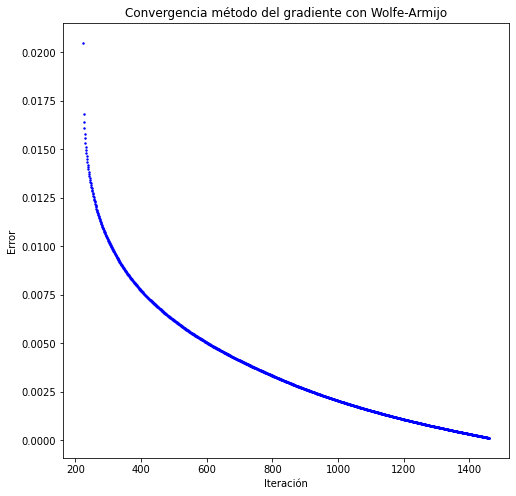

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y1, e1, s=2, c='b')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.title('Convergencia método del gradiente con Wolfe-Armijo')
plt.show()

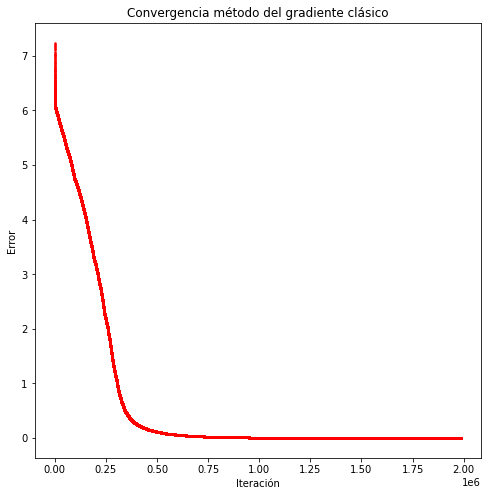

In [ ]:
e2 = classic_gradient.errors[250:]
y2 = [i for i in range(250, len(e2)+250)]
plt.figure(figsize=(8,8))
plt.scatter(y2, e2, s=2, c='r')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.title('Convergencia método del gradiente clásico')
plt.show()

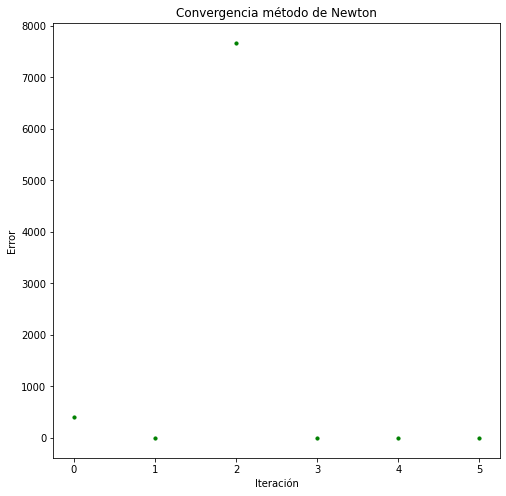

In [ ]:
e3 = newton.errors
y3 = [i for i in range(len(e3))]
plt.figure(figsize=(8,8))
plt.scatter(y3, e3, s=10, c='g')

plt.xlabel('Iteración')
plt.ylabel('Error')
plt.title('Convergencia método de Newton')
plt.show()